In [1]:
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet121, InceptionV3, MobileNetV2, InceptionResNetV2
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
import seaborn as sns

In [ ]:
# Check GPU availability
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_path = "/content/drive/MyDrive/RCP-CNN-1/CoLeaf-augmented"

In [5]:
train_dir= '/content/drive/MyDrive/RCP-CNN-1/CoLeaf-augmented/train'
val_dir= '/content/drive/MyDrive/RCP-CNN-1/CoLeaf-augmented/eval'
test_dir= '/content/drive/MyDrive/RCP-CNN-1/CoLeaf-augmented/test'

In [24]:
# Define image size and batch size
img_size = (224, 224)  # Example image size, adjust as needed
batch_size = 32  # Example batch size, adjust as needed

In [25]:
# Data generators
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest'
                                   )

val_test_datagen = ImageDataGenerator(rescale=1./255)

In [26]:
# Cargar los datasets usando tf.data
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=False
)

# Capture class names before transforming datasets
class_names = train_dataset.class_names

Found 17301 files belonging to 10 classes.
Found 3708 files belonging to 10 classes.
Found 3712 files belonging to 10 classes.


In [27]:
# Función de aumento de datos
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image, label

In [28]:
# Aplicar aumentos y optimizaciones al pipeline
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.map(augment, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(buffer_size=1000)
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

val_dataset = val_dataset.cache()
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)

test_dataset = test_dataset.cache()
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


In [29]:
def build_model(base_model):
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = layers.Dropout(0.5)(x)  # 50% Dropout
    predictions = layers.Dense(len(class_names), activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [30]:
def build_and_train_model(base_model, model_name):
    for layer in base_model.layers:
        layer.trainable = False  # Freeze all layers in the base model

    model = build_model(base_model)

    # Learning rate schedule
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-3,
        decay_steps=100000,
        decay_rate=0.96,
        staircase=True
    )

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Train the model
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=50
        #callbacks=[early_stopping]
    )

    return model, history

In [31]:
def plot_history(history, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(10, 8))
    plt.subplot(2, 1, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{model_name} Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'{model_name} Training and Validation Loss')

    plt.show()

In [32]:
# Fine-tuning function
def fine_tune_model(model, base_model, fine_tune_at=100):
    # Unfreeze the base model from the specified layer onward
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False
    for layer in base_model.layers[fine_tune_at:]:
        layer.trainable = True

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    history_fine = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=10  # Fine-tune for an additional 10 epochs
    )

    return history_fine

In [33]:
# Function to train MobileNetV2
def train_mobilenetv2():
    # Initialize MobileNetV2 base model
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    for layer in base_model.layers:
        layer.trainable = False  # Freeze the base model layers

    # Build and train the model using MobileNetV2 as the base
    model, history = build_and_train_model(base_model, 'MobileNetV2')

    # Plot the training history
    plot_history(history, 'MobileNetV2')

    return model, base_model  # Return the model and the base model for further fine-tuning or evaluation

Epoch 1/50
541/541 ━━━━━━━━━━━━━━━━━━━━ 266s 126ms/step - accuracy: 0.7273 - loss: 2.1719 - val_accuracy: 0.8172 - val_loss: 1.5006
Epoch 2/50
541/541 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step - accuracy: 0.8287 - loss: 1.3907 - val_accuracy: 0.8236 - val_loss: 1.1853
Epoch 3/50
541/541 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step - accuracy: 0.8479 - loss: 1.0765 - val_accuracy: 0.8374 - val_loss: 1.0131
Epoch 4/50
541/541 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step - accuracy: 0.8561 - loss: 0.9301 - val_accuracy: 0.8430 - val_loss: 0.9620
Epoch 5/50
541/541 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step - accuracy: 0.8505 - loss: 0.8969 - val_accuracy: 0.8236 - val_loss: 0.9996
Epoch 6/50
541/541 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step - accuracy: 0.8469 - loss: 0.9079 - val_accuracy: 0.8239 - val_loss: 1.0013
Epoch 7/50
541/541 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step - accuracy: 0.8470 - loss: 0.9204 - val_accuracy: 0.8376 - val_loss: 0.9486
Epoch 8/50
541/541 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step - accuracy: 0.8604 - loss: 0.8467 

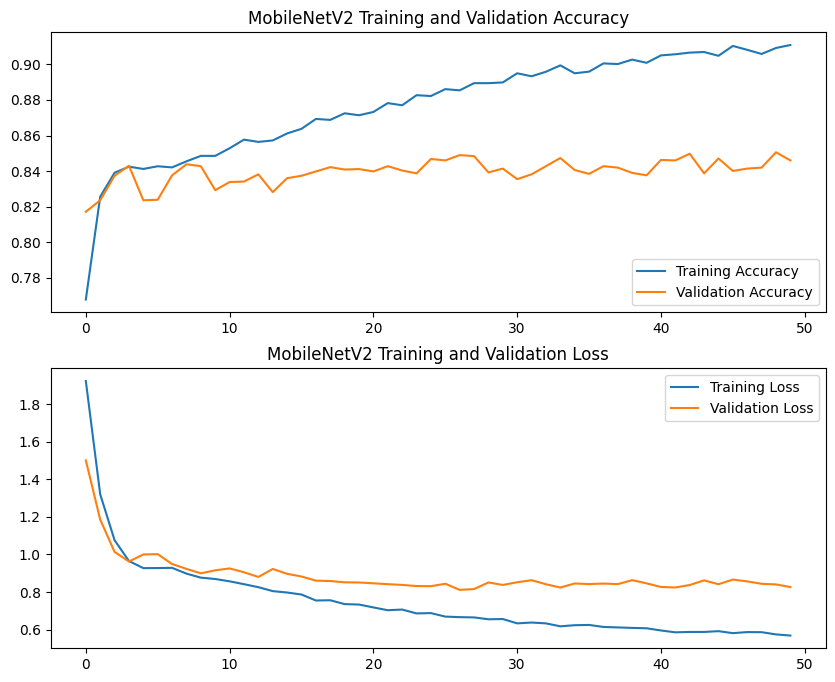

Epoch 1/10
541/541 ━━━━━━━━━━━━━━━━━━━━ 59s 72ms/step - accuracy: 0.4822 - loss: 2.4156 - val_accuracy: 0.7217 - val_loss: 1.8095
Epoch 2/10
541/541 ━━━━━━━━━━━━━━━━━━━━ 26s 49ms/step - accuracy: 0.7659 - loss: 1.1299 - val_accuracy: 0.7824 - val_loss: 1.2661
Epoch 3/10
541/541 ━━━━━━━━━━━━━━━━━━━━ 26s 49ms/step - accuracy: 0.8146 - loss: 0.8766 - val_accuracy: 0.8074 - val_loss: 1.0270
Epoch 4/10
541/541 ━━━━━━━━━━━━━━━━━━━━ 27s 49ms/step - accuracy: 0.8473 - loss: 0.7608 - val_accuracy: 0.8198 - val_loss: 0.9118
Epoch 5/10
541/541 ━━━━━━━━━━━━━━━━━━━━ 27s 49ms/step - accuracy: 0.8686 - loss: 0.6863 - val_accuracy: 0.8301 - val_loss: 0.8692
Epoch 6/10
541/541 ━━━━━━━━━━━━━━━━━━━━ 26s 49ms/step - accuracy: 0.8954 - loss: 0.6101 - val_accuracy: 0.8341 - val_loss: 0.8527
Epoch 7/10
541/541 ━━━━━━━━━━━━━━━━━━━━ 27s 49ms/step - accuracy: 0.9096 - loss: 0.5579 - val_accuracy: 0.8403 - val_loss: 0.8419
Epoch 8/10
541/541 ━━━━━━━━━━━━━━━━━━━━ 27s 49ms/step - accuracy: 0.9249 - loss: 0.5140 - 

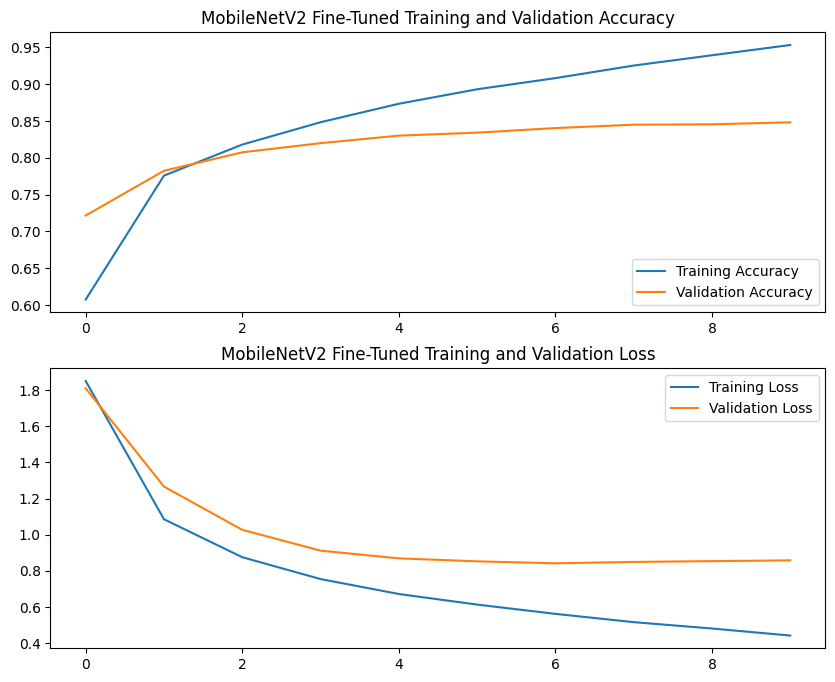

In [34]:
# Train the MobileNetV2 model
mobilenetv2_model, mobilenetv2_base_model = train_mobilenetv2()

# Fine-tune the MobileNetV2 model
history_fine = fine_tune_model(mobilenetv2_model, mobilenetv2_base_model, fine_tune_at=100)
plot_history(history_fine, 'MobileNetV2 Fine-Tuned')

## Evaluation

In [36]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = mobilenetv2_model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

116/116 ━━━━━━━━━━━━━━━━━━━━ 362s 3s/step - accuracy: 0.8592 - loss: 0.8167
Test Accuracy: 85.29%
Test Loss: 0.8387


In [37]:
predictions = mobilenetv2_model.predict(test_dataset)

116/116 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step


In [38]:
# Convert predictions to class labels
predicted_classes = tf.argmax(predictions, axis=1)
true_classes = tf.concat([y for x, y in test_dataset], axis=0)
true_classes = tf.argmax(true_classes, axis=1)

### Metrics of evaluation based on confusion matrix

In [39]:
# Display classification report
from sklearn.metrics import classification_report
print(classification_report(true_classes, predicted_classes, target_names=class_names))

              precision    recall  f1-score   support

       boron       0.88      0.85      0.86       401
     calcium       0.77      0.82      0.80       374
     healthy       0.95      0.96      0.95       382
        iron       0.92      0.91      0.91       365
   magnesium       0.83      0.86      0.85       372
   manganese       0.86      0.83      0.85       363
    nitrogen       0.86      0.87      0.87       354
      others       0.79      0.75      0.77       362
  phosphorus       0.81      0.82      0.82       367
    potasium       0.85      0.85      0.85       372

    accuracy                           0.85      3712
   macro avg       0.85      0.85      0.85      3712
weighted avg       0.85      0.85      0.85      3712



### Confusion Matrix

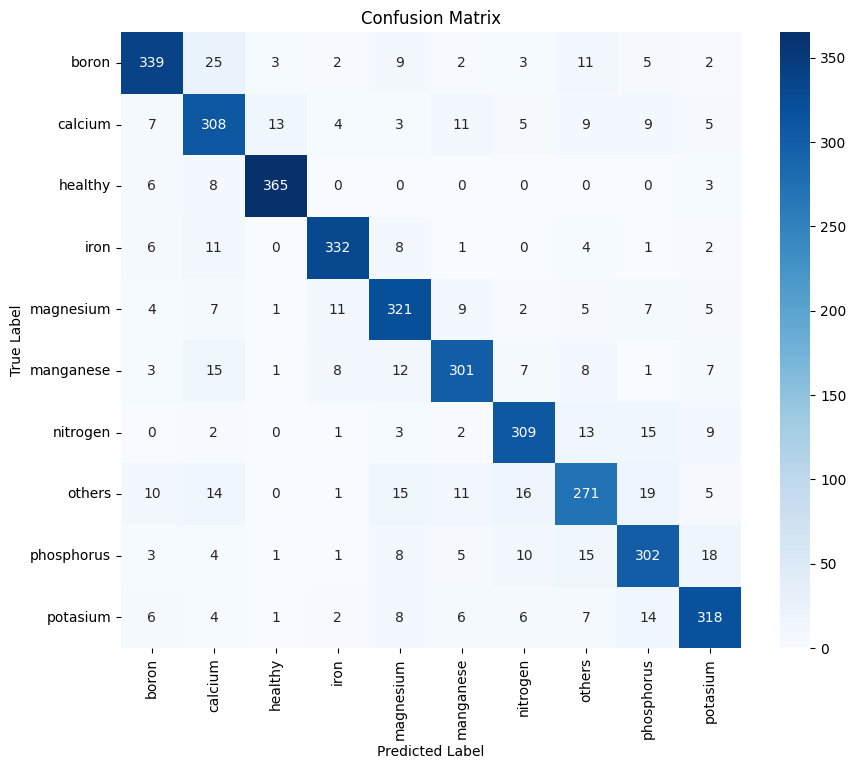

In [40]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute and plot confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()